In [1]:
import pydot
import matplotlib.pyplot as plt

In [2]:
dot_file_path = 'Datasets/LesMiserables.dot'


with open(dot_file_path, 'r') as dot_file:
    dot_data = dot_file.read()

graph = pydot.graph_from_dot_data(dot_data)

nodes = graph[0].get_nodes()
edges = graph[0].get_edges()
#print(edges.get_name())


#for edge in edges:
    #print(child_count)
 #   print("("+edge.get_source()+","+edge.get_destination()+ ")")  

### COUNTING THE NUMBER OF CHILD NODES FOR EACH NODE

In [20]:
#COUNTING THE NUMBER OF CHILD NODES FOR EACH NODE
node_child_count = {node.get_name(): 0 for node in nodes}
node_parent_count = {node.get_name(): 0 for node in nodes}

node_childs = {node.get_name(): [] for node in nodes}
node_parents = {node.get_name(): [] for node in nodes}

for edge in graph[0].get_edges():
    source = edge.get_source()
    destination = edge.get_destination()
    if source in node_child_count:
        node_child_count[source] += 1 
        node_childs[source].append(destination)
    
    if destination in node_parent_count:
        node_parent_count[destination] += 1 
        node_parents[destination].append(source)
        
#print(node_childs)
#print([node for node in list(node_parents.keys()) if len(node_parents[node])==0 and len(node_childs) == 0])


## ORGANZING THE NODES THROUGHOUT THE GRAPH

### TREES

In [4]:
node_positions = {node.get_name(): (0, 0) for node in nodes}
done_nodes= []
lonely_nodes_h = 4

for edge in edges:
    #print(edge)#.get_source())
#    print(node_childs[str(edge.get_destination())])
    parent_x = node_positions[str(edge.get_source())][0]
    parent_y = node_positions[str(edge.get_source())][1]
    if len(node_childs[str(edge.get_source())]) == 1 and int(edge.get_destination()) not in done_nodes:
        #print(edge)
        child_x = parent_x + 3
        child_y = parent_y
        node_positions[edge.get_destination()] = (child_x, child_y)
        done_nodes.append(int(edge.get_destination()))
    
    
    elif len(node_childs[str(edge.get_source())]) > 1 and int(edge.get_destination()) not in done_nodes:
        if len(node_childs[str(edge.get_source())])%2 != 0:
            max_y = (node_child_count[str(edge.get_source())]-1)*2
        else:
            max_y = (node_child_count[str(edge.get_source())]-1)*2+1
        for child in node_childs[str(edge.get_source())]:
            child_x = parent_x + 2
            child_y = parent_y + max_y
            node_positions[child] = (child_x, child_y)
            max_y -=5
            done_nodes.append(int(edge.get_destination()))
#node_parent_count[] == 0 and node_parent_count == 0:
#node_poistion[]
            #print(max_y)
#    print("#####################")
print(node_positions)

{'1': (0, 0), '2': (3, 0), '3': (5, 16), '4': (5, 11), '5': (5, 6), '6': (5, 1), '7': (5, -4), '8': (5, -9), '9': (5, -14), '10': (5, -19), '11': (5, -24), '12': (7, 40), '13': (7, 35), '14': (7, 30), '15': (7, 25), '16': (7, 20), '24': (7, 15), '25': (9, 4), '26': (11, 20), '27': (13, 44), '28': (15, 54), '29': (7, -10), '30': (9, -11), '32': (9, -21), '33': (7, -25), '34': (7, -30), '35': (7, -35), '36': (7, -40), '37': (7, -45), '38': (7, -50), '39': (7, -55), '44': (15, 49), '45': (9, -7), '49': (13, 14), '50': (15, 44), '52': (17, 47), '56': (19, 39), '59': (15, 35), '65': (15, 5), '69': (15, -10), '70': (15, -15), '71': (13, -6), '72': (15, -20), '73': (15, 24), '17': (9, 39), '18': (15, 59), '19': (9, 29), '20': (9, 24), '21': (9, 19), '22': (9, 14), '23': (9, 9), '31': (9, -16), '42': (13, 24), '43': (13, 19), '51': (17, 52), '40': (13, 34), '41': (13, 29), '76': (15, -35), '55': (19, 44), '46': (9, -12), '53': (19, 54), '58': (15, 40), '63': (17, 41), '47': (15, 50), '48': (18

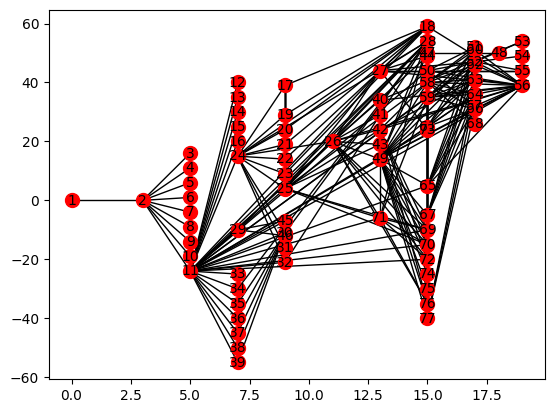

In [5]:
#HOW TO PLOT A GENERAL GRAPH
for edge in edges:
    start_node = edge.get_source()
    end_node = edge.get_destination()
    start_pos = node_positions[start_node]
    end_pos = node_positions[end_node]
    position = str(str(edge.get_attributes())).rfind(':')
    w = str(edge.get_attributes())[position+3:-2]
    plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-',linewidth=1) 

# Draw nodes
for node, pos in node_positions.items():
    plt.plot(pos[0], pos[1], 'ro',markersize=10)  # 'ro' is red circle
    plt.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')

# Set plot limits
#plt.xlim(-0.5, 3.5)
#plt.ylim(-1.5, 1.5)

# Turn off axis
#plt.axis('off')

plt.savefig('plots/plot.png')
plt.show()

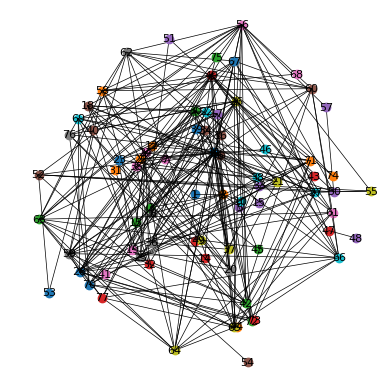

In [40]:
import matplotlib.pyplot as plt
import numpy as np

#def cartesian_to_polar(x, y):
#    radius = np.sqrt(x**2 + y**2)
#    theta = np.arctan2(y, x)
#    return radius, theta

def plot_radial_layout(node_positions, node_childs):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines['polar'].set_visible(False)
    
    #plot node and edges
    for node, (x, y) in node_positions.items():
        radius, theta = x, y
        ax.plot(theta, radius, 'o') #plot node
        ax.text(theta, radius, str(node), ha='center', va='center', fontsize=8)
        # Draw edges
        for child in node_childs[node]:
            child_x, child_y = node_positions[child]
            child_radius, child_theta = child_x, child_y
            ax.plot([theta, child_theta], [radius, child_radius], 'k-',linewidth =0.5)

    plt.show()

# Your existing code for node positions and child nodes

# Example usage
plot_radial_layout(node_positions, node_childs)


### Sort the nodes based on the number of childs

ValueError: too many values to unpack (expected 2)

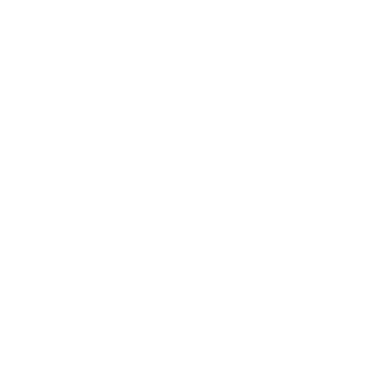

In [42]:
sorted_node_child_count = sorted_dict = dict(sorted(node_childs.items(), key=lambda item: len(item[1]), reverse=True))

def plot_radial_layout (sorted_node_child_count, node_childs):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines['polar'].set_visible(False)
    
    #plot node and edges
    for node, (x, y) in sorted_node_child_count.items():
        radius, theta = x, y
        ax.plot(theta, radius, 'o') #plot node
        ax.text(theta, radius, str(node), ha='center', va='center', fontsize=8)
        # Draw edges
        for child in node_childs[node]:
            child_x, child_y = sorted_node_child_count[child]
            child_radius, child_theta = child_x, child_y
            ax.plot([theta, child_theta], [radius, child_radius], 'k-',linewidth =0.5)

    plt.show()

# Your existing code for node positions and child nodes

# Example usage
plot_radial_layout (sorted_node_child_count, node_childs)

# General Code

In [390]:
#for node in nodes:
 #   print("Node name:", node.get_name())
  #  print("Node label:", node.get_label())
   # print("Node attributes:", node.get_attributes())
    #print("Node shape:", node.get_shape())
    #print("Node style:", node.get_style())
    #print("Node position:", node.get_pos())
    
    
#for edge in edges:
 #   print("Source:", edge.get_source())
  #  print("Destination:", edge.get_destination())
    #print("Edge attributes:", edge.get_attributes())
    #position = str(str(edge.get_attributes())).rfind(':')
    #w = str(edge.get_attributes())[position+3:-2]
    #print(w)
    #print("Edge style:", edge.get_style())
    #print("Edge label:", edge.get_label())
    #print("Edge color:", edge.get_color())

# TRASH

In [272]:
#IGNORE: TREE WITH NODES
node_positions = {node.get_name(): (0, 0) for node in nodes}
#node_positions['1'] = (0, 0)
lonely_nodes = 

for node in nodes:
    max_y = node_child_count[str(node.get_name())]-1
    
    parent_x = node_positions[str(node.get_name())][0]
    parent_y = node_positions[str(node.get_name())][1]
    if len(node_childs[str(node.get_name())]) == 1:
        
        child_x = parent_x + 2
        child_y = parent_y  # Assuming you want to keep the same y-coordinate
        node_positions[child] = (child_x, child_y)
    
    elif len(node_childs[str(node.get_name())]) == 0:
        
    else:
        for child in node_childs[str(node.get_name())]:
            child_x = parent_x + 2
            child_y = parent_y + max_y
            node_positions[child] = (child_x, child_y)
            max_y -= 2
    #print(max_distance)
            
            
print(node_positions) 

{'1': (0, 0), '2': (0, 0), '3': (2, 8), '4': (4, 9), '5': (2, 4), '6': (2, 2), '7': (2, 0), '8': (2, -2), '9': (2, -4), '10': (2, -6), '11': (6, 9), '12': (8, 41), '13': (8, 39), '14': (8, 37), '15': (8, 35), '16': (8, 33), '24': (8, 31), '25': (10, 29), '26': (12, 37), '27': (14, 49), '28': (16, 54), '29': (18, 65), '30': (18, 63), '32': (18, 61), '33': (8, 15), '34': (18, 59), '35': (20, 67), '36': (22, 70), '37': (24, 72), '38': (26, 73), '39': (28, 73), '44': (18, 57), '45': (20, 66), '49': (18, 55), '50': (16, 50), '52': (18, 52), '56': (20, 49), '59': (22, 49), '65': (24, 47), '69': (20, 49), '70': (22, 51), '71': (24, 52), '72': (26, 52), '73': (18, 43), '17': (10, 43), '18': (12, 48), '19': (14, 52), '20': (16, 55), '21': (18, 57), '22': (20, 58), '23': (22, 58), '31': (10, 21), '42': (28, 53), '43': (30, 56), '51': (18, 54), '40': (22, 59), '41': (14, 43), '76': (24, 59), '55': (22, 55), '46': (20, 64), '53': (20, 55), '58': (30, 54), '63': (32, 55), '47': (20, 73), '48': (0, 

In [ ]:
#COUNT THE NUMBER OF EDGES OF EACH NODE
node_edge_count = {node.get_name(): 0 for node in nodes}

for edge in graph[0].get_edges():
    s = edge.get_source()
    d = edge.get_destination()
    if s in node_edge_count:
        node_edge_count[s] += 1
    if d in node_edge_count:
        node_edge_count[d] += 1

for node_name, edge_count in node_edge_count.items():
    print("Node:", node_name, ", Number of edges:", edge_count)

In [103]:
#HOW TO CREATE THE DEFAULT LAYOUT

with open(dot_file_path, 'r') as dot_file:
    dot_data = dot_file.read()

# Create a graph object from the .dot data
graph = pydot.graph_from_dot_data(dot_data)

# Set the layout algorithm to "dot" (or any other supported layout type)
graph[0].set_graph_defaults(layout="dot")

# Render the graph with Graphviz
output_file_path = 'dot_layout_graph.png'
graph[0].write_png(output_file_path)

print("Graph with dot layout saved as:", output_file_path)

Graph with dot layout saved as: dot_layout_graph.png


In [87]:
#HOW TO CREATE THE RADIAL LAYOUT
graph[0].set_graph_defaults(layout="twopi")
output_file_path = 'radial_graph.png'
graph[0].write_png(output_file_path)